In [1]:
##### import numpy.random

import scipy
import scipy.optimize
import scipy.constants
import math
import numpy 
import uncertainties
import uncertainties.unumpy 

import matplotlib.axes
import matplotlib.pyplot
import scipy.misc
import scipy.special
import scipy.stats
from random import *
from scipy.special import xlogy
import sys
from scipy.stats import norm
import pandas as pd

def is_number(series):
    counter = 0
    g = numpy.zeros(len(series))
    for i in series:
        try:
            float(i)
            boolArray[counter] = True
        except ValueError:
            boolArray[counter] = False
        counter = counter + 1
    return boolArray

# time in days for MRad sample = 46 (sample D)
t = 60*60*24*46


import brewer2mpl

# brewer2mpl.get_map args: set name  set type  number of colors
bmap = brewer2mpl.get_map('Paired', 'qualitative', 10)
colors = bmap.mpl_colors


import sys
#!{sys.executable} -m pip install periodictable
from periodictable import *





In [2]:
E1 = numpy.array([255.1374417, 242.1378577 , 242.4019787])
E1_uncert = numpy.array([3.25, 3, 2.9])

E2 = numpy.array([349.9259299 , 327.8340934,  319.9849217])
E2_uncert = numpy.array([108.65,  96.65, 98.55])

tau = numpy.array([85.2772561 , 85.7645192,  75.8940842])
tau_uncert = numpy.array([18.11 , 17.445, 16.26])

E1_vals = uncertainties.unumpy.uarray(E1, E1_uncert)
E2_vals = uncertainties.unumpy.uarray(E2, E2_uncert)
tau_vals = uncertainties.unumpy.uarray(tau, tau_uncert)

n = (E1_vals*E2_vals*tau_vals)/(E1_vals+E2_vals)

print(n)

[12582.95596428797+/-3140.584300562624
 11944.582798783918+/-2854.4994113154166
 10467.389941587053+/-2639.1464214267266]


In [3]:
# Read in decay data from: https://www.nndc.bnl.gov/nudat2/dec_searchi.jsp
#For Decay Radiation, intensities are listed per 100 decays of the parent nucleus. 
#A  	Element	Z  	N  	Par. Elevel	Unc. 	JPi       	Dec Mode	T1/2 (txt)    	T1/2 (num)        	Daughter	Radiation	Rad subtype 	Rad Ene.  	Unc       	EP Ene.   	Unc       	Rad Int.  	Unc       	Dose        	Unc       


filename = "/Users/jvl2xv/anaconda/AFRL_RV/Transmutation/Gamma_Decay_NNDC_BNL.csv"
expr_decay_info = pd.read_csv(filename, header=0)
# remove the annihilation ones
expr_decay_info = expr_decay_info.loc[expr_decay_info['Rad_Type_2'] != "Annihil.    "]
print(expr_decay_info)

        A  Element   Z   N Par_Elevel Par_Elevel_Unc         Jpi   DecMode  \
0      43  SC       21  22          0                 7/2-        EC         
1      44  SC       21  23          0                 2+          EC         
2      44  SC       21  23     271.24             10  6+          EC         
3      44  TI       22  22          0                 0+          EC         
4      45  TI       22  23          0                 7/2-        EC         
5      47  SC       21  26          0                 7/2-        B-         
6      48  SC       21  27          0                 6+          B-         
7      48  V        23  25          0                 4+          EC         
8      49  V        23  26          0                 7/2-        EC         
9      50  V        23  27          0                 6+          EC         
10     48  CR       24  24          0                 0+          EC         
11     51  CR       24  27          0                 7/2-      

In [4]:
# Read in the processed FISPACTII results - as element-wise / semiconductor-wise table

# NUCLIDE_elem NUCLIDE_A  Indicator ATOMS_num         GRAMS_num        Bq       b-Energy_kW    a-Energy_kW   g-Energy_kW    DOSE_RATE_SvHr   INGESTION_Sv  INHALATION_Sv Bq/A2_Ratio     HALF_LIFE_s            
filename = 'FISPACT_RESULTS_PIVOT_All.csv'
FISPACT_RESULTS_PIVOT = pd.read_csv(filename)

print(FISPACT_RESULTS_PIVOT.columns)


# Read in the processed GEANT4 results - as element-wise / semiconductor-wise table
filename = 'GEANT4_RESULTS_PIVOT_All.csv'
GEANT4_RESULTS_PIVOT = pd.read_csv(filename)

print(GEANT4_RESULTS_PIVOT.columns)


# Read in the experimental values
filename = "FinalExprData_1Mrad_E_Count_Stdev.txt"
expr_energy_count_stdev = numpy.loadtxt(filename)

Index([u'Element', u'GaAs_Nuclides', u'HgCdTe_Nuclides', u'InAsSb_Nuclides',
       u'InAs_Nuclides', u'InSbBi_5Bi_Nuclides', u'InSbBi_05Bi_Nuclides',
       u'InSb_Nuclides', u'Si_Nuclides', u'Symbol', u'Particle'],
      dtype='object')
Index([u'Element', u'GaAs_Nuclides', u'HgCdTe_Nuclides', u'InAsSb_Nuclides',
       u'InAs_Nuclides', u'InSbBi_5Bi_Nuclides', u'InSbBi_05Bi_Nuclides',
       u'InSb_Nuclides', u'Si_Nuclides', u'nFile', u'Particle', u'Symbol'],
      dtype='object')


In [5]:
n_mat = 1

# get the data out of the pandas sim pivot, this is all the simulated counts
isotopes_sim = GEANT4_RESULTS_PIVOT['Particle']
total_sim_counts = GEANT4_RESULTS_PIVOT['GaAs_Nuclides'].values
total_sim_counts_uncert = uncertainties.unumpy.uarray(GEANT4_RESULTS_PIVOT['GaAs_Nuclides'].values, numpy.sqrt(GEANT4_RESULTS_PIVOT['GaAs_Nuclides'].values))

len_sim_data = GEANT4_RESULTS_PIVOT.shape[0]

# get the data out of the pandas decay data, this is all the decay constants
isotopes_decay_data = numpy.array(expr_decay_info['Nuclide_Formatted'])
isotopes_decay_data_forPlot = numpy.array(expr_decay_info['Nuclide_Formatted_forPlot'])
parent_E_level_decay_data = numpy.array(expr_decay_info['Par_Elevel'])
energies_decay_data = numpy.array(expr_decay_info['Rad_Energy'])
len_decay_data = expr_decay_info.shape[0]
decay_consts_decay_data = (math.log(2)/(numpy.array(expr_decay_info['T_1/2_SEC'])))*(numpy.array(expr_decay_info['Rad_Intensity'])/100)
#print(decay_consts_decay_data.shape)


# get the data out of the pandas decay data, this is all the FISPACT-II data
isotopes_calc = FISPACT_RESULTS_PIVOT['Particle']
total_calc_counts_uncert = uncertainties.unumpy.uarray(FISPACT_RESULTS_PIVOT['GaAs_Nuclides'].values, numpy.sqrt(FISPACT_RESULTS_PIVOT['GaAs_Nuclides'].values))
total_calc_counts = FISPACT_RESULTS_PIVOT['GaAs_Nuclides'].values
len_calc_data = FISPACT_RESULTS_PIVOT.shape[0]


# experimental values
filename = "FinalExprData_1Mrad_E_Count_Stdev.txt"
expr_energy_count_stdev = numpy.loadtxt(filename)
expr_count_uncert = uncertainties.unumpy.uarray(expr_energy_count_stdev[:,1], expr_energy_count_stdev[:,2])



In [6]:
### GEANT4 ###

# Matching the decay data rows, sum over all of the matching counts from simulation, store in finalCounts_by_material

GEANT_4_Gammas_uncert = uncertainties.unumpy.uarray(numpy.zeros(len_decay_data),numpy.zeros(len_decay_data))
GEANT_4_Gammas = numpy.zeros(len_decay_data)

  
for sim_data_rownum, sim_data_element in enumerate(isotopes_sim):   
    for decay_data_rownum, decay_data_element in enumerate(isotopes_decay_data):     
        # because GaAs, all are in ground state
        if (numpy.char.lower(str(decay_data_element)) == numpy.char.lower(str(sim_data_element))):
            #print(numpy.char.lower(str(decay_data_element)), numpy.char.lower(str(sim_data_element)))
            GEANT_4_Gammas_uncert[decay_data_rownum] = total_sim_counts_uncert[sim_data_rownum]
            GEANT_4_Gammas[decay_data_rownum] = total_sim_counts[sim_data_rownum]
            #print(decay_data_element, parent_E_level_decay_data[decay_data_rownum] )

    
# Calculate the gamma spectrum by material, energies in energies_decay_data, counts sim in finalCounts_by_material
# GaAs is column 0

sim_n_runs = 100
sim_num_per_run = 10000000
numParticles_sim = sim_n_runs*sim_num_per_run
numParticles_fisp = 9.60574503032e+12  
# 0 degree incidence, the first value is 100 krad, converting to 1 MRad
numParticles_expr = 7.5*10**11 * 10



GEANT_4_Activities = GEANT_4_Gammas*decay_consts_decay_data
GEANT_4_Activities_uncert = GEANT_4_Gammas_uncert*decay_consts_decay_data

GEANT_4_Activities_GaAs = GEANT_4_Activities*numParticles_expr/numParticles_sim
GEANT_4_Activities_GaAs_uncert = GEANT_4_Activities_uncert*numParticles_expr/numParticles_sim



            
        
  

In [7]:
numParticles_expr

7500000000000.0

In [8]:
### FISPACT-II ###

# Matching the decay data rows, sum over all of the matching counts from calculation, store in finalCounts_by_material

FISPACT_Gammas = numpy.zeros(len_decay_data)
FISPACT_Gammas_uncert = uncertainties.unumpy.uarray(numpy.zeros(len_decay_data),numpy.zeros(len_decay_data))

  
for calc_data_rownum, calc_data_element in enumerate(isotopes_calc):   
    for decay_data_rownum, decay_data_element in enumerate(isotopes_decay_data):     

        # because GaAs, all are in ground state
        if (numpy.char.lower(str(decay_data_element)) == numpy.char.lower(str(calc_data_element)) ):
            FISPACT_Gammas_uncert[decay_data_rownum] = total_calc_counts_uncert[calc_data_rownum]
            FISPACT_Gammas[decay_data_rownum] = total_calc_counts[calc_data_rownum]
            #print(decay_data_element, parent_E_level_decay_data[decay_data_rownum] )
        decay_data_rownum += 1       
    calc_data_rownum += 1
    
# Calculate the gamma spectrum by material, energies in energies_decay_data, counts calc in finalCounts_by_material
# GaAs is column 0


FISPACT_Activities = FISPACT_Gammas*decay_consts_decay_data
FISPACT_Activities_uncert = FISPACT_Gammas_uncert*decay_consts_decay_data


FISPACT_Activities_GaAs_uncert = FISPACT_Activities_uncert*numParticles_expr/numParticles_fisp
FISPACT_Activities_GaAs = FISPACT_Activities*numParticles_expr/numParticles_fisp


  

In [9]:
sum(FISPACT_Gammas)

29547424141.18173

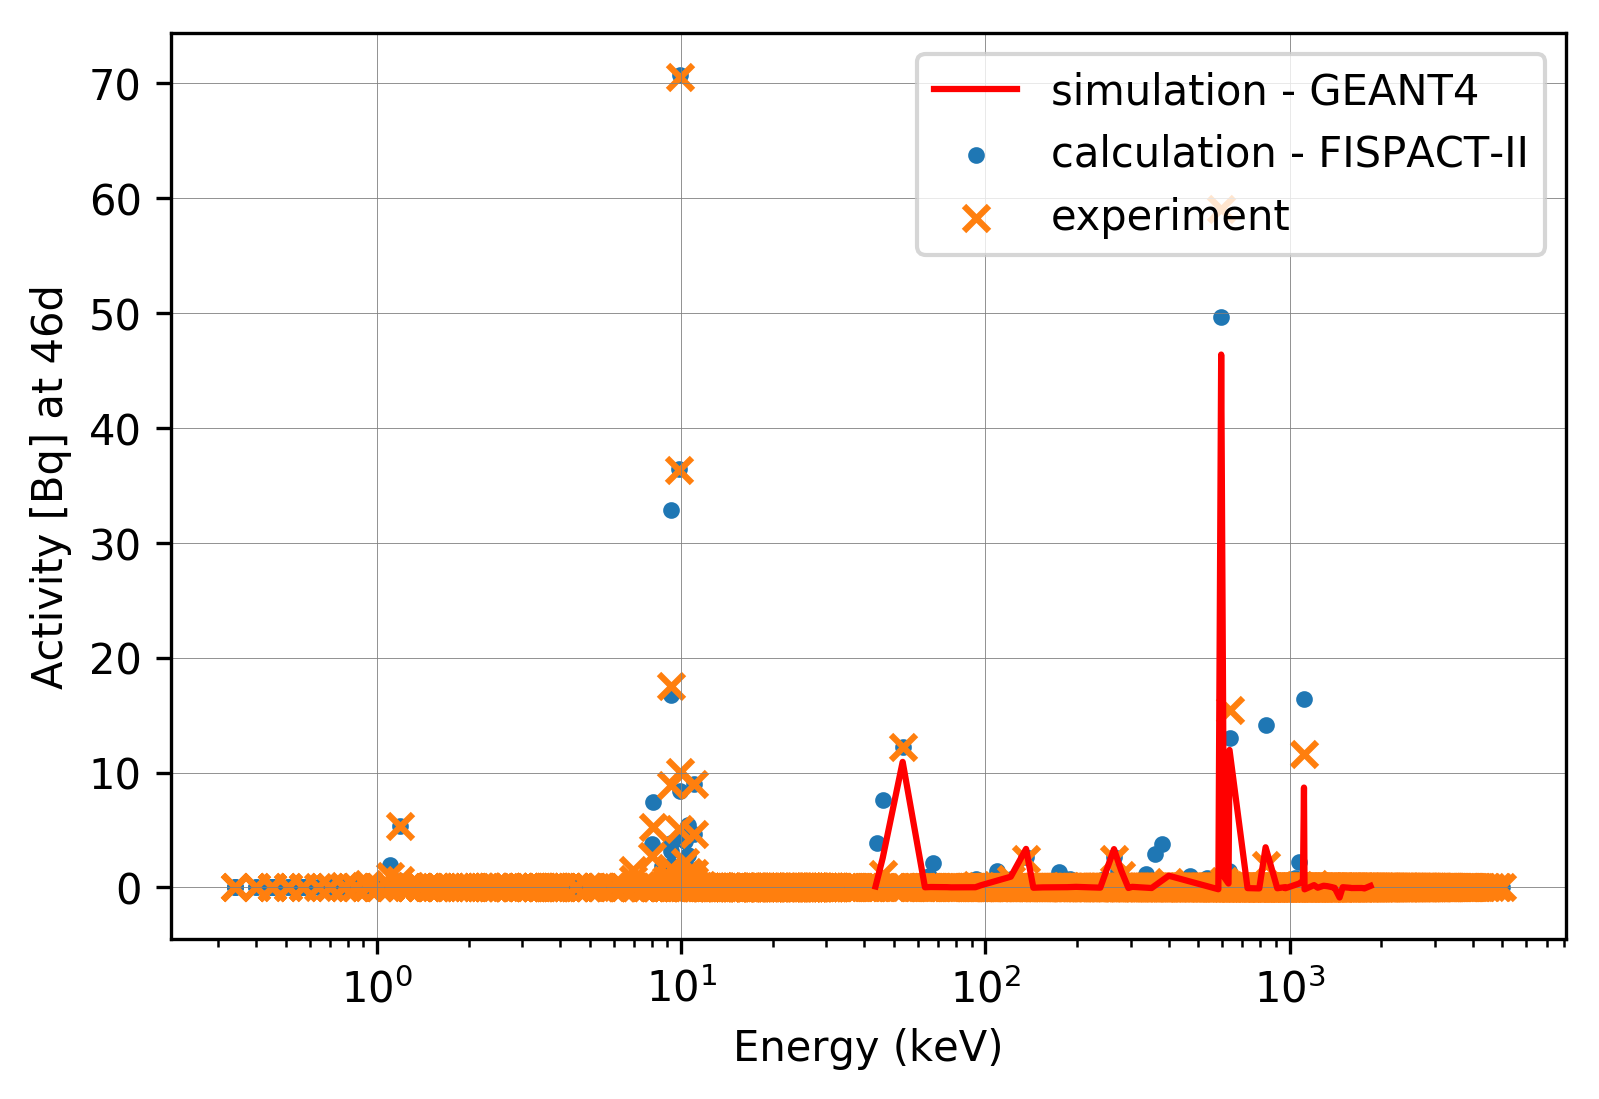

<Figure size 1800x1200 with 0 Axes>

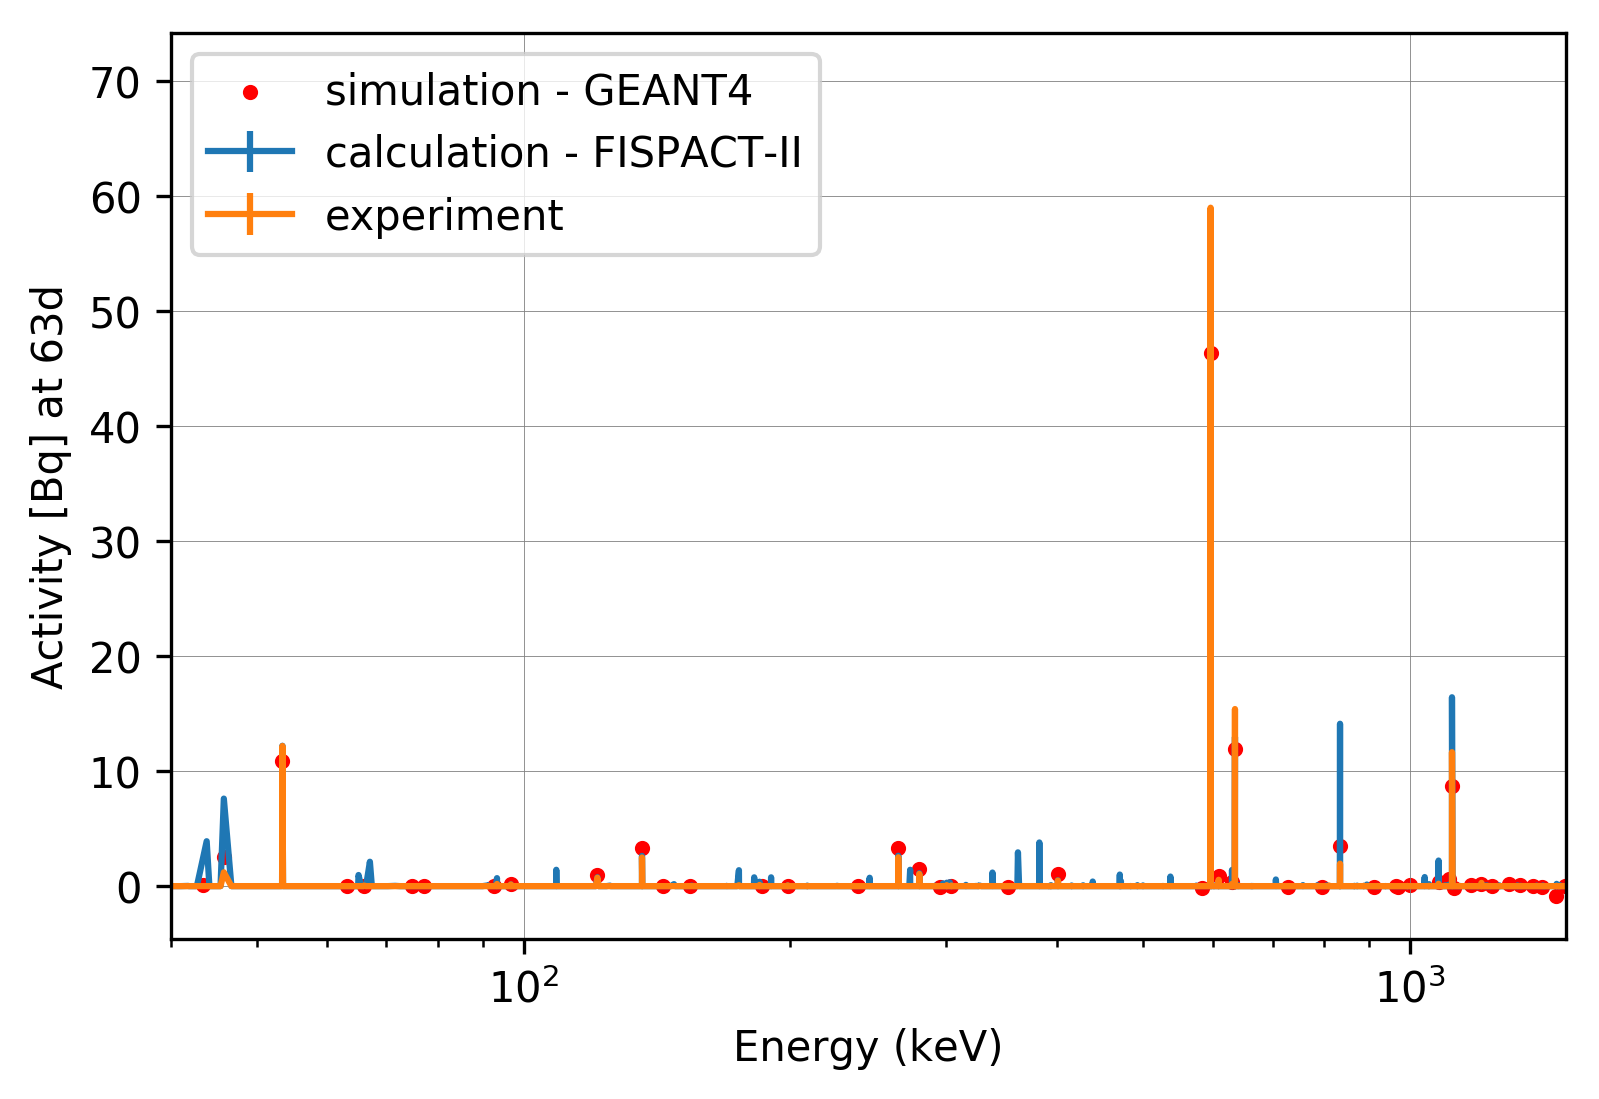

In [12]:

energies_decay_data_toPlot_GEANT4 = energies_decay_data[:]
data_toPlot_GEANT4 = GEANT_4_Activities_GaAs[:]

energies_decay_data_toPlot_FISPACT = energies_decay_data[:]
data_toPlot_FISPACT = FISPACT_Activities_GaAs[:]

matplotlib.pyplot.figure(dpi=300)
matplotlib.pyplot.scatter(energies_decay_data_toPlot_GEANT4, data_toPlot_GEANT4, marker=".")
matplotlib.pyplot.scatter(energies_decay_data_toPlot_FISPACT, data_toPlot_FISPACT, marker="x")

matplotlib.pyplot.plot(expr_energy_count_stdev[:,0], expr_energy_count_stdev[:,1], c='red')
matplotlib.pyplot.xlabel('Energy (keV)')
matplotlib.pyplot.ylabel("Activity [Bq] at 46d")
#matplotlib.pyplot.xlim([100,1600])
matplotlib.pyplot.grid(b=None, which='major', axis='both', color='grey', linestyle='-', linewidth=.2)
matplotlib.pyplot.legend(['simulation - GEANT4', 'calculation - FISPACT-II','experiment'])
matplotlib.pyplot.xscale('log') #, nonposy='clip')


matplotlib.pyplot.show()

matplotlib.pyplot.figure(dpi=300)
energies_decay_data_toPlot_GEANT4 = energies_decay_data[:]
data_toPlot_GEANT4 = GEANT_4_Activities_GaAs[:]

energies_decay_data_toPlot_FISPACT = energies_decay_data[:]
data_toPlot_FISPACT = FISPACT_Activities_GaAs[:]

matplotlib.pyplot.figure(dpi=300)
matplotlib.pyplot.errorbar(energies_decay_data_toPlot_GEANT4, uncertainties.unumpy.nominal_values(data_toPlot_GEANT4), uncertainties.unumpy.std_devs(data_toPlot_GEANT4))
matplotlib.pyplot.errorbar(energies_decay_data_toPlot_FISPACT, uncertainties.unumpy.nominal_values(data_toPlot_FISPACT), uncertainties.unumpy.std_devs(data_toPlot_FISPACT))

matplotlib.pyplot.scatter(expr_energy_count_stdev[:,0], expr_energy_count_stdev[:,1], s=7, c='red')
matplotlib.pyplot.xlabel('Energy (keV)')
matplotlib.pyplot.ylabel("Activity [Bq] at 63d")
matplotlib.pyplot.xlim([40,1500])
matplotlib.pyplot.grid(b=None, which='major', axis='both', color='grey', linestyle='-', linewidth=.2)
matplotlib.pyplot.legend(['simulation - GEANT4', 'calculation - FISPACT-II','experiment'])
matplotlib.pyplot.xscale('log')#, nonposy='clip')


matplotlib.pyplot.show()


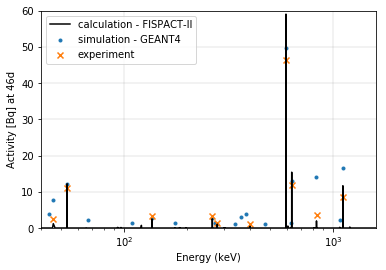

In [13]:

data_toPlot_GEANT4 = uncertainties.unumpy.nominal_values(data_toPlot_GEANT4)
data_toPlot_FISPACT = uncertainties.unumpy.nominal_values(data_toPlot_FISPACT)

GEANT4_over1Bq_indices = numpy.argwhere(data_toPlot_GEANT4>1)
FISPACT_over1Bq_indices = numpy.argwhere(data_toPlot_FISPACT>1)
EXPR_over1Bq_indices = numpy.argwhere(expr_energy_count_stdev[:,1]>1)

# PREVIOUS TELLS US THAT ERROR BARS ARE TOO SMALL TO BE SEEN 


fig = matplotlib.pyplot.figure(figsize=(6, 4))
#ax = fig.add_subplot(111)

matplotlib.pyplot.scatter(energies_decay_data_toPlot_GEANT4[GEANT4_over1Bq_indices], data_toPlot_GEANT4[GEANT4_over1Bq_indices], marker=".")
#matplotlib.pyplot.scatter(energies_decay_data_toPlot_FISPACT, data_toPlot_FISPACT, marker="x")
matplotlib.pyplot.plot(energies_decay_data_toPlot_FISPACT, data_toPlot_FISPACT, color='black')

matplotlib.pyplot.scatter(expr_energy_count_stdev[EXPR_over1Bq_indices,0], expr_energy_count_stdev[EXPR_over1Bq_indices,1], marker="x")
#matplotlib.pyplot.plot(expr_energy_count_stdev[:,0], expr_energy_count_stdev[:,1])


matplotlib.pyplot.xlabel('Energy (keV)')
matplotlib.pyplot.ylabel("Activity [Bq] at 46d")
matplotlib.pyplot.xlim([40,1600])
matplotlib.pyplot.ylim([0,60])
matplotlib.pyplot.grid(b=None, which='major', axis='both', color='grey', linestyle='-', linewidth=.2)
#matplotlib.pyplot.legend(['simulation - GEANT4', 'calculation - FISPACT-II','experiment'])
matplotlib.pyplot.legend([ 'calculation - FISPACT-II','simulation - GEANT4','experiment'])

matplotlib.pyplot.xscale('log') #, nonposy='clip')


'''
labeledE = []

counter = 0
for xy in zip(energies_decay_data,data_toPlot_GEANT4):
    label = isotopes_decay_data_forPlot[counter]
    if data_toPlot_GEANT4[counter] > 1:
        matplotlib.pyplot.annotate('%s' % label, xy=xy, textcoords='data',fontsize=5,color='grey', fontweight='bold', rotation=0)   
        labeledE.append(energies_decay_data[counter])
    else:
        matplotlib.pyplot.annotate('(%s)' % label, xy=xy, textcoords='data',fontsize=4,color='black',alpha=0) 

    counter = counter + 1
    

    
counter = 0
for xy in zip(energies_decay_data,data_toPlot_FISPACT):
    label = isotopes_decay_data_forPlot[counter]
    if data_toPlot_FISPACT[counter] > 1 and not(energies_decay_data[counter] in labeledE):
        matplotlib.pyplot.annotate('%s' % label, xy=xy, textcoords='data',fontsize=5,color='grey', fontweight='bold', rotation=90)
        labeledE.append(energies_decay_data[counter])
    else:
        matplotlib.pyplot.annotate('(%s)' % label, xy=xy, textcoords='data',fontsize=4,color='black',alpha=0) 

    counter = counter + 1
    

    
counter = 0
for xy in zip(expr_energy_count_stdev[:,0],expr_energy_count_stdev[:,1]):
    label = isotopes_decay_data_forPlot[counter]
    if expr_energy_count_stdev[counter,1] > 1 and not(energies_decay_data[counter] in labeledE):
        matplotlib.pyplot.annotate('%s' % label, xy=xy, textcoords='data',fontsize=5,color='black', fontweight='bold')
        labeledE.append(energies_decay_data[counter])
    else:
        matplotlib.pyplot.annotate('(%s)' % label, xy=xy, textcoords='data',fontsize=4,color='black',alpha=0) 

    counter = counter + 1
    
'''


#matplotlib.pyplot.show()
matplotlib.pyplot.savefig("final_fig.png", dpi=300)


In [154]:
def plotErrors(d1, d2, name1, name2):
    energies = numpy.arange(0,1600)

    fig = matplotlib.pyplot.figure(dpi=100)
    percent_error1 =  d1
    percent_error2 =  d2

    legend = [name1, name2]

    error_1 = uncertainties.unumpy.nominal_values(percent_error1)
    error_2 = uncertainties.unumpy.nominal_values(percent_error1)
    nonzeros_1 = numpy.nonzero(error_1)
    nonzeros_2 = numpy.nonzero(error_2)

    matplotlib.pyplot.scatter(energies[nonzeros_1], error_1[nonzeros_1], marker="+")
    matplotlib.pyplot.scatter(energies[nonzeros_2], error_2[nonzeros_2], marker="x")

    matplotlib.pyplot.xlabel('Energy (keV)')
    matplotlib.pyplot.ylabel("Relative Error")
    matplotlib.pyplot.xlim([68,1600])
    matplotlib.pyplot.ylim([-2,2])
    matplotlib.pyplot.grid(b=None, which='major', axis='both', color='grey', linestyle='-', linewidth=.2)
    #matplotlib.pyplot.legend(['simulation - GEANT4', 'calculation - FISPACT-II','experiment'])
    matplotlib.pyplot.legend(legend)

    matplotlib.pyplot.xscale('log') #, nonposy='clip')
    #matplotlib.pyplot.yscale('log') #, nonposy='clip')
    matplotlib.pyplot.show()




In [ ]:
# Compare the total activities

print('simulated activity: ', sum(FISPACT_Activities_GaAs))
print('calculated activity: ', sum(GEANT_4_Activities_GaAs))
# from the experimental post-process files where I saves as uncertainties array
print('experimental activity: ', sum(expr_count_uncert))


num_sim_missed = 0
num_calc_missed = 0

geant4_percent_error_calc = uncertainties.unumpy.uarray(numpy.zeros(1600),numpy.zeros(1600))
expr_percent_error_calc = uncertainties.unumpy.uarray(numpy.zeros(1600),numpy.zeros(1600))

geant4_percent_error_expr = uncertainties.unumpy.uarray(numpy.zeros(1600),numpy.zeros(1600))
fispact_percent_error_expr = uncertainties.unumpy.uarray(numpy.zeros(1600),numpy.zeros(1600))

fispact_percent_error_sim = uncertainties.unumpy.uarray(numpy.zeros(1600),numpy.zeros(1600))
expr_percent_error_sim = uncertainties.unumpy.uarray(numpy.zeros(1600),numpy.zeros(1600))



binning_increments = [1,5,10]

for binning_increment in binning_increments:
    
    counts_geant = uncertainties.unumpy.uarray(numpy.zeros(1600),numpy.zeros(1600))
    counts_fispact = uncertainties.unumpy.uarray(numpy.zeros(1600),numpy.zeros(1600))
    counts_expr = uncertainties.unumpy.uarray(numpy.zeros(1600),numpy.zeros(1600))
    
    print(binning_increment)

    def myround(x, base=binning_increment):
        return base * round(x/base)

    mse_calc = 0
    mse_sim = 0
    for E_keV in numpy.arange(100,1600,binning_increment):
        simCount = uncertainties.unumpy.uarray(0,0)
        calcCount = uncertainties.unumpy.uarray(0,0)
        exprCount = uncertainties.unumpy.uarray(0,0)
        
        for index, simsE in enumerate(energies_decay_data_toPlot_GEANT4):
            if (myround(simsE) == E_keV):
                simCount = simCount + GEANT_4_Activities_GaAs_uncert[index]


        for index, calcsE in enumerate(energies_decay_data_toPlot_FISPACT):
            if (myround(calcsE) == E_keV):
                calcCount = calcCount + FISPACT_Activities_GaAs_uncert[index]


        for index, exprE in enumerate(expr_energy_count_stdev[:,0]):  
            if (myround(exprE) == E_keV):
                exprCount = exprCount + expr_count_uncert[index]


        counts_geant[E_keV] = simCount
        counts_fispact[E_keV] = calcCount
        counts_expr[E_keV] = exprCount

        #print(simCount, calcCount, exprCount)
        mse_calc = mse_calc + (exprCount - calcCount)**2
        mse_sim = mse_sim + (exprCount - simCount)**2


        if (exprCount > 0):
            geant4_percent_error_expr[E_keV] = (exprCount - simCount)/exprCount
            fispact_percent_error_expr[E_keV] = (exprCount - calcCount)/exprCount


        if (calcCount > 0):
            geant4_percent_error_calc[E_keV] = (calcCount - simCount)/calcCount
            expr_percent_error_calc[E_keV] = (calcCount - exprCount)/calcCount
            

        if (simCount > 0):
            expr_percent_error_sim[E_keV] = (simCount - exprCount)/simCount
            fispact_percent_error_sim[E_keV] = (simCount - calcCount)/simCount
            
            
    plotErrors(geant4_percent_error_expr, fispact_percent_error_expr, 'GEANT4 wrt EXPR', 'FISPACT wrt EXPR' )  
    plotErrors(geant4_percent_error_calc, expr_percent_error_calc, 'GEANT4 wrt FISPACT', 'EXPR wrt FISPACT' )  
    plotErrors(expr_percent_error_sim, fispact_percent_error_sim, 'EXPR wrt GEANT4', 'FISPACT wrt GEANT4' )  
            
    print(sum(counts_geant), sum(counts_fispact),sum(counts_expr))


  

In [ ]:
# Relative error in top n experimental peaks
# this gives you > 0.10
n = 13
# in keV
tolerance = 5

numExpr = len(expr_count_uncert)
geant4_percent_error_expr_some =  uncertainties.unumpy.uarray(numpy.zeros(numExpr),numpy.zeros(numExpr))
fispact_percent_error_expr_some = uncertainties.unumpy.uarray(numpy.zeros(numExpr),numpy.zeros(numExpr))



for num, index in enumerate(numpy.argsort(-expr_count_uncert)):
    
    expr_activity = expr_count_uncert[index]
    expr_energy = expr_energy_count_stdev[index,0]
    
    simCount = uncertainties.unumpy.uarray(0,0)
    calcCount = uncertainties.unumpy.uarray(0,0)
    
    print(expr_energy, expr_activity, " : ")
        
    for i, simsE in enumerate(energies_decay_data_toPlot_GEANT4):
        if (abs(myround(simsE) - expr_energy) < tolerance):
            simCount = simCount + GEANT_4_Activities_GaAs_uncert[i]

    for i, calcsE in enumerate(energies_decay_data_toPlot_FISPACT):
        if (abs(myround(calcsE) - expr_energy) < tolerance):
            calcCount = calcCount + FISPACT_Activities_GaAs_uncert[i]
    
    
    geant4_percent_error_expr_some[index] =  (expr_activity - simCount)/expr_activity
    fispact_percent_error_expr_some[index] = (expr_activity - calcCount)/expr_activity
  
    #print(expr_activity, expr_energy, " : " , geant4_percent_error_expr_some[index], fispact_percent_error_expr_some[index])
    

if True:
    top_indices = numpy.argsort(-expr_count_uncert)
    top_indices = top_indices[0:n]
    
    energies = expr_energy_count_stdev[:,0]
    fig = matplotlib.pyplot.figure(dpi=100)
    percent_error1 =  geant4_percent_error_expr_some
    percent_error2 =  fispact_percent_error_expr_some

    legend = ['GEANT4 wrt EXPR', 'FISPACT wrt EXPR']

    error_1 = uncertainties.unumpy.nominal_values(percent_error1)
    error_2 = uncertainties.unumpy.nominal_values(percent_error1)

    matplotlib.pyplot.scatter(energies[top_indices], error_1[top_indices], marker="+")
    matplotlib.pyplot.scatter(energies[top_indices], error_2[top_indices], marker="x")

    matplotlib.pyplot.xlabel('Energy (keV)')
    matplotlib.pyplot.ylabel("Relative Error")
    matplotlib.pyplot.xlim([68,1600])
    #matplotlib.pyplot.ylim([-2,2])
    matplotlib.pyplot.grid(b=None, which='major', axis='both', color='grey', linestyle='-', linewidth=.2)
    #matplotlib.pyplot.legend(['simulation - GEANT4', 'calculation - FISPACT-II','experiment'])
    matplotlib.pyplot.legend(legend)

    matplotlib.pyplot.xscale('log') #, nonposy='clip')
    #matplotlib.pyplot.yscale('log') #, nonposy='clip')
    matplotlib.pyplot.show()






In [126]:
expr_energy_count_stdev[:,0]

array([  43.51,   45.92,   53.43,   63.25,   66.1 ,   74.84,   77.16,
         92.69,   96.76,  121.15,  136.02,  143.73,  154.08,  185.71,
        198.57,  238.6 ,  264.68,  279.54,  295.25,  303.82,  351.92,
        400.66,  583.28,  595.92,  609.  ,  630.  ,  634.8 ,  727.63,
        795.08,  834.18,  911.31,  964.85,  969.05, 1000.87, 1077.47,
       1106.57, 1115.58, 1120.32, 1173.15, 1204.11, 1238.09, 1293.57,
       1332.15, 1377.39, 1407.73, 1460.52, 1495.89, 1587.58, 1591.96,
       1728.85, 1763.48, 1846.24])

In [127]:
        #print(geant4_percent_error[E_keV],fispact_percent_error[E_keV] )

        if (exprCount > 0 and calcCount == 0 ):
            num_calc_missed += 1
        if (exprCount > 0 and simCount == 0 ):
            num_sim_missed += 1

    #mse_calc = uncertainties.unumpy.sqrt(mse_calc/1200)
    #mse_sim = uncertainties.unumpy.sqrt(mse_sim/1200)

    mse_calc = (mse_calc/(1600-82))
    mse_sim = (mse_sim/(1600-82))

    #print('MSE: ', uncertainties.unumpy.sqrt(mse_calc), uncertainties.unumpy.sqrt(mse_sim))
    #print('# missed: ', 1-num_calc_missed/1600, 1-num_sim_missed/1600)



    # root mean error = 4.4458+/-0.0004 5.41+/-0.0